In [187]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

from datetime import datetime
import matplotlib.pyplot as plt
from math import ceil

In [188]:
df = pd.read_sas('a2z_insurance.sas7bdat')
df.set_index('CustID', inplace=True)

In [189]:
df.head(5)

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
1.0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
3.0,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
4.0,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
5.0,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [190]:
df.shape

(10296, 13)

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10296 entries, 1.0 to 10296.0
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FirstPolYear   10266 non-null  float64
 1   BirthYear      10279 non-null  float64
 2   EducDeg        10279 non-null  object 
 3   MonthSal       10260 non-null  float64
 4   GeoLivArea     10295 non-null  float64
 5   Children       10275 non-null  float64
 6   CustMonVal     10296 non-null  float64
 7   ClaimsRate     10296 non-null  float64
 8   PremMotor      10262 non-null  float64
 9   PremHousehold  10296 non-null  float64
 10  PremHealth     10253 non-null  float64
 11  PremLife       10192 non-null  float64
 12  PremWork       10210 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.1+ MB


In [192]:
non_metric_features = ["EducDeg", "Children"]
metric_features=df.columns.drop(non_metric_features).to_list()

In [193]:
df_info = pd.DataFrame(columns={"column", "NaN", "NaN %"})
for index, value in df.isna().sum().iteritems():
    df_temp = pd.DataFrame({"column" : index, "NaN" : [value], "NaN %" : round(value*100 /len(df), 2)})
    df_info = pd.concat([df_info, df_temp], ignore_index=True)
    df_info.sort_values(by="NaN", ascending=False, inplace=True)

print(df_info)

           column  NaN NaN %
0        PremLife  104  1.01
12       PremWork   86  0.84
1      PremHealth   43  0.42
2        MonthSal   36  0.35
3       PremMotor   34  0.33
4    FirstPolYear   30  0.29
5        Children   21   0.2
6       BirthYear   17  0.17
7         EducDeg   17  0.17
8      GeoLivArea    1  0.01
9      CustMonVal    0   0.0
10     ClaimsRate    0   0.0
11  PremHousehold    0   0.0


### %%%% explicar que como nenhuma coluna tem mais de 3% de Nans, não eliminamos os nans, vamos imputar

In [194]:
# # Generate random missing values on column MaxSpeed
# mask = np.random.choice([True, False], size=df['PremLife'].shape, p=[0.3, 0.7])
# mask[mask.all(),-1] = 0
# df['PremLife'] = df['PremLife'].mask(mask)

In [195]:
#Check duplicates
df.duplicated().sum()

3

In [196]:
df.drop_duplicates(inplace=True)

In [197]:
#Check duplicates
df.duplicated().sum()

0

# Fill Nans
### This data don't have a lot of missing values, but we will fill them with 4 different approaches and then test it when doing clusters
#### For each approach we are going to plot a range of data (using the metric with more missing values VS another metric), so that it is possible to identify the missing values ​​filled in. Since if we showed all the data, it would be impossible to see them graphically
#### All filled missing values are going to be plotted in red color

### - Using mode for both metric and non metric:

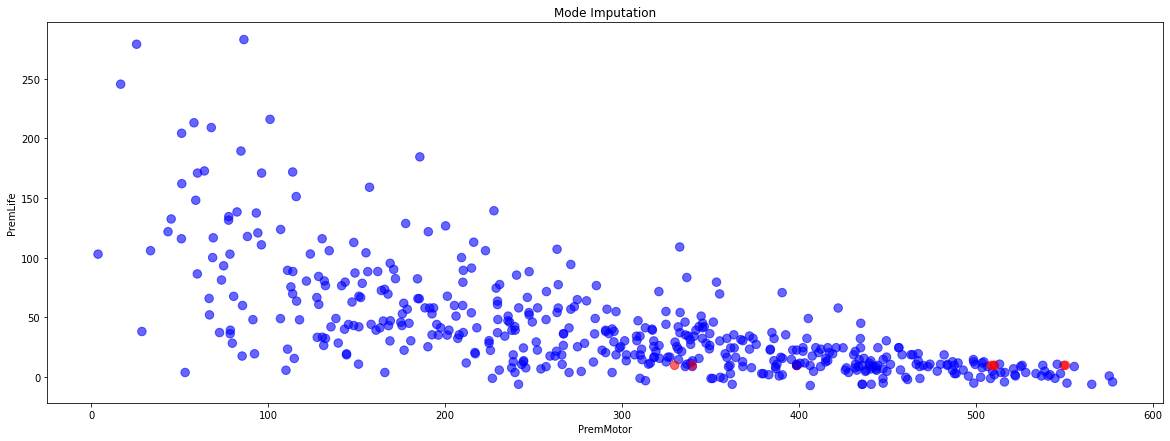

In [198]:
# Mode Imputation

df_mode = df.copy()
mode_imputer = SimpleImputer(strategy='most_frequent')
df_mode[metric_features] = mode_imputer.fit_transform(df_mode[metric_features].values)
df_mode[non_metric_features] = mode_imputer.fit_transform(df_mode[non_metric_features].values)

# Scatter plot

fig = plt.Figure()
null_values = df['PremLife'].isnull()
fig = df_mode[4020:4502].plot(x='PremMotor', y='PremLife', kind='scatter', c=null_values[4020:4502], cmap='bwr', title='Mode Imputation', colorbar=False, alpha=0.6, figsize=(20,7), s=72)


### - Using mean for metric and mode for non metric:

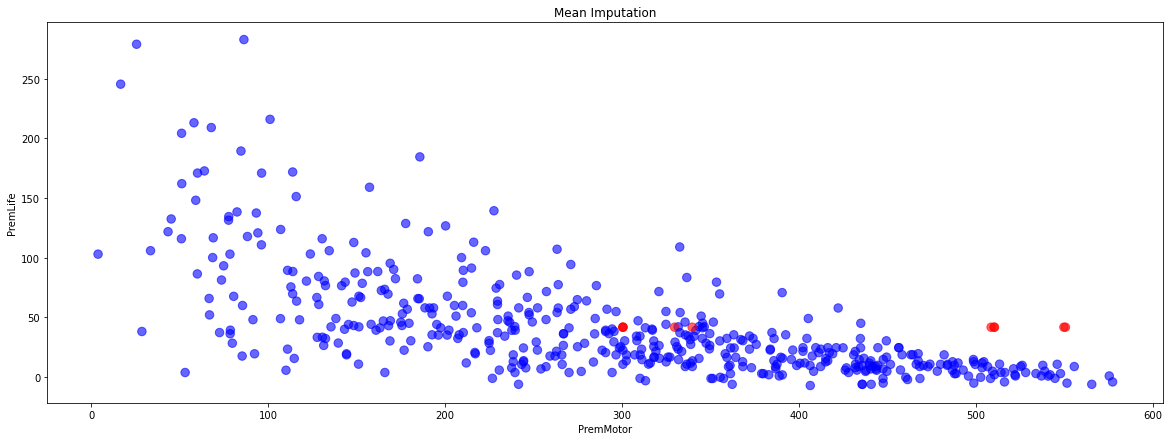

In [199]:
# Mean Imputation

df_mean = df.copy()
mean_imputer = SimpleImputer(strategy='mean')
df_mean[metric_features] = mean_imputer.fit_transform(df_mean[metric_features].values)
df_mean[non_metric_features] = mode_imputer.fit_transform(df_mean[non_metric_features].values)


# Scatter plot

fig = plt.Figure()
null_values = df['PremLife'].isnull()
fig = df_mean[4020:4502].plot(x='PremMotor', y='PremLife', kind='scatter', c=null_values[4020:4502], cmap='bwr', title='Mean Imputation', colorbar=False, alpha=0.6, figsize=(20,7), s=72)



### - Using KNN Imputer for both metric and non metric:

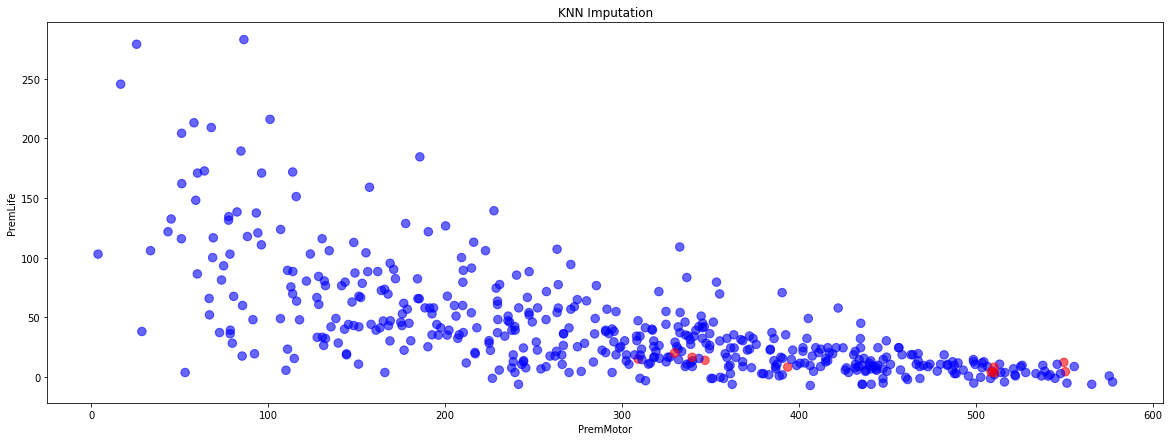

In [200]:
df_kmeans=df.copy()

imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_kmeans[metric_features] = imputer.fit_transform(df_kmeans[metric_features])

#transform categorical features into numeric ones while preserving the NaN values
df_kmeans[non_metric_features] = df_kmeans[non_metric_features].apply(lambda series: pd.Series(
        LabelEncoder().fit_transform(series[series.notnull()]),
        index=series[series.notnull()].index
    ))

df_kmeans[non_metric_features] = imputer.fit_transform(df_kmeans[non_metric_features])

# Scatter plot

fig = plt.Figure()
null_values = df['PremLife'].isnull()
fig = df_kmeans[4020:4502].plot(x='PremMotor', y='PremLife', kind='scatter', c=null_values[4020:4502], cmap='bwr', title='KNN Imputation', colorbar=False, alpha=0.6, figsize=(20,7), s=72)


### - Using linear interpolation for both metric and non metric:

<AxesSubplot:title={'center':'PremLife'}, xlabel='CustID'>

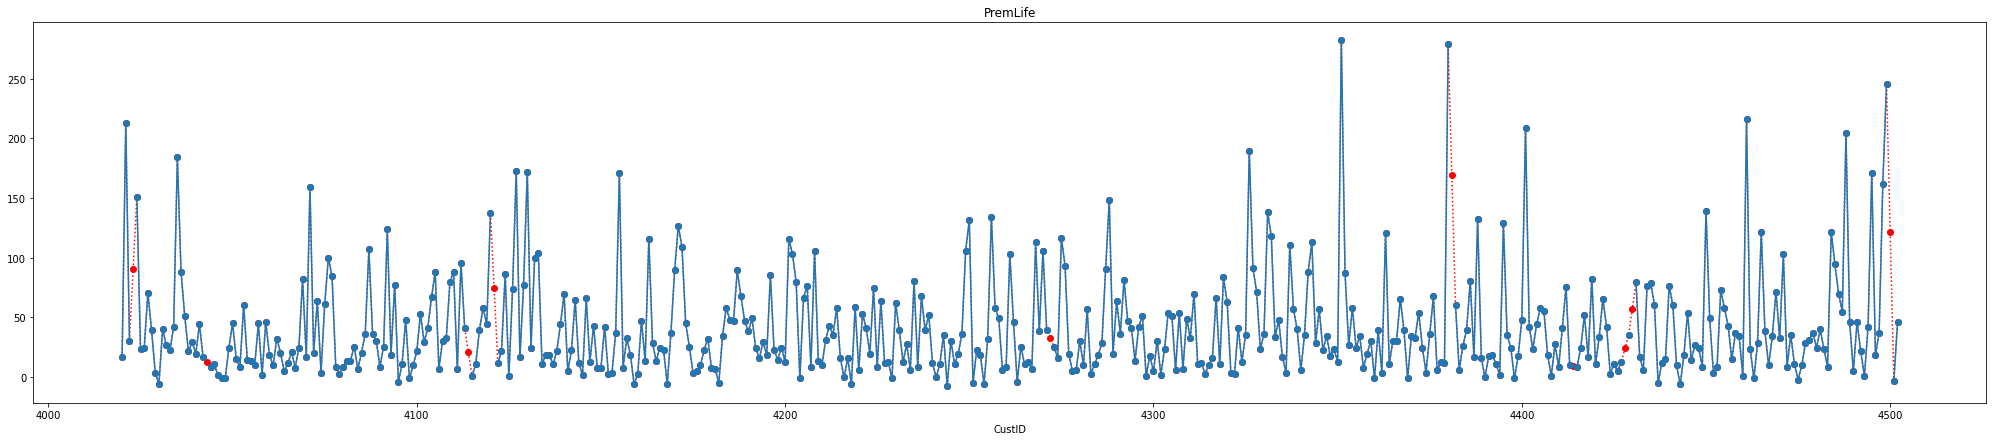

In [201]:
# Imputing with linear interpolation
linear_interpolation = df.interpolate(method='linear')

# Plot imputed data

linear_interpolation['PremLife'][4020:4502].plot(color='red', marker='o', linestyle='dotted')
df['PremLife'][4020:4502].plot(title='PremLife', marker='o', figsize=(35,7))

In [202]:
df_filled=df_kmeans.copy()

In [203]:
#convert some variables to int
df_filled = df_filled.astype({'FirstPolYear': int, 'BirthYear': int, 'MonthSal': int , 'GeoLivArea': int, 'Children': int})
#convert index to int
df_filled.index = df_filled.index.astype(int)

In [204]:
df_filled.sample(5)

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
9241,1975,1977,2.0,1978,1,1,-45.56,1.03,478.09,9.45,70.68,29.45,8.89
7939,1994,1950,1.0,3789,1,0,191.04,0.67,256.27,102.25,236.60,22.45,40.23
2347,1985,1979,2.0,2388,4,1,408.87,0.18,506.54,-60.00,68.79,12.67,4.00
2467,1996,1970,2.0,2237,2,1,-82.79,1.08,322.06,127.80,183.59,19.67,38.12
128,1978,1952,1.0,3481,3,0,-19.11,1.00,132.58,750.15,168.70,71.79,65.90


In [205]:
#Check if Nans were all filled
df_filled.isna().sum()

FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

In [206]:
# print columns with Nans
nans_index = df.isna().any(axis=1)
df[nans_index]

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
22.0,1977.0,1958.0,b'2 - High School',NaN,3.0,1.0,111.37,0.80,407.52,111.70,100.13,24.67,30.34
69.0,1983.0,1977.0,b'2 - High School',1399.0,4.0,1.0,476.65,0.33,330.73,186.70,211.15,NaN,15.78
139.0,1979.0,1976.0,b'2 - High School',2538.0,2.0,1.0,149.59,0.69,194.26,305.60,NaN,37.34,17.67
144.0,1996.0,1990.0,b'3 - BSc/MSc',NaN,4.0,1.0,-42.45,1.02,146.36,353.95,220.04,121.80,42.01
185.0,1993.0,1984.0,b'2 - High School',2419.0,4.0,1.0,-62.23,1.07,NaN,253.95,230.60,5.89,43.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10011.0,NaN,1947.0,b'2 - High School',3959.0,2.0,NaN,-128.24,1.14,177.81,153.35,311.28,67.79,35.45
10058.0,1983.0,1980.0,b'2 - High School',1569.0,4.0,1.0,222.60,0.55,235.60,211.15,NaN,32.34,68.79
10143.0,1986.0,1985.0,b'3 - BSc/MSc',1652.0,3.0,1.0,55.67,0.88,257.05,94.45,308.39,NaN,13.78


In [207]:
#print the same columns with Nans filled
df_filled[nans_index]

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
22,1977,1958,1.0,2541,3,1,111.37,0.80,407.520,111.70,100.130,24.670,30.340
69,1983,1977,1.0,1399,4,1,476.65,0.33,330.730,186.70,211.150,33.784,15.780
139,1979,1976,1.0,2538,2,1,149.59,0.69,194.260,305.60,226.598,37.340,17.670
144,1996,1990,2.0,1721,4,1,-42.45,1.02,146.360,353.95,220.040,121.800,42.010
185,1993,1984,1.0,2419,4,1,-62.23,1.07,264.428,253.95,230.600,5.890,43.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10011,1990,1947,1.0,3959,2,0,-128.24,1.14,177.810,153.35,311.280,67.790,35.450
10058,1983,1980,1.0,1569,4,1,222.60,0.55,235.600,211.15,247.602,32.340,68.790
10143,1986,1985,2.0,1652,3,1,55.67,0.88,257.050,94.45,308.390,23.338,13.780


In [208]:
#copy to df
df=df_filled.copy()

In [209]:
#convert birth year to age
df['Age'] = 2016-df['BirthYear']
df.drop(columns='BirthYear', inplace=True)
#remove from metric_features list
metric_features.remove('BirthYear')
#add age to metric_features list
metric_features.append('Age')

In [210]:
# print of unique values to check coherence
for col in df[non_metric_features]:
    print('\033[1;3mUnique values of "' + col + '"\033[0m ')
    print(df[col].unique())
    print('\n')

Unique values of "EducDeg" 
[1.  0.  2.  3.  1.2 1.4]


Unique values of "Children" 
[1 0]




<AxesSubplot:title={'center':'Children Countplot'}, xlabel='Children', ylabel='count'>

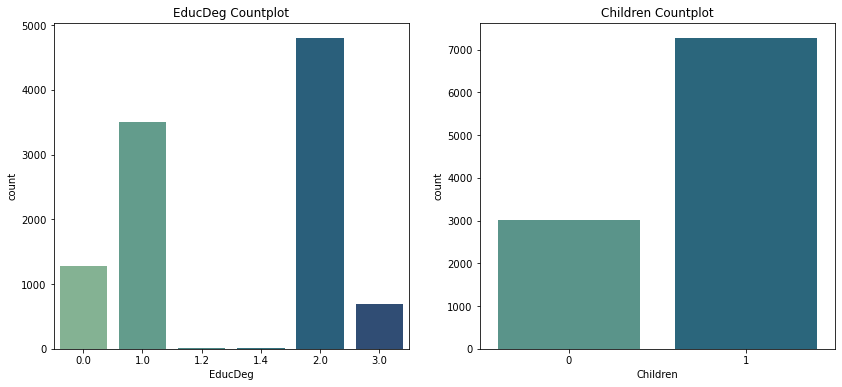

In [211]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].title.set_text('EducDeg Countplot')
ax[1].title.set_text('Children Countplot')
sns.countplot(data=df, x="EducDeg", ax=ax[0], palette='crest', order=df.EducDeg.value_counts().index.sort_values(), dodge=False)
sns.countplot(data=df, x="Children", ax=ax[1], palette='crest',  dodge=False)


In [212]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
FirstPolYear,10293.0,1991.049257,510.596929,1974.00,1980.00,1986.00,1992.00,53784.00
EducDeg,10293.0,1.478753,0.795032,0.00,1.00,2.00,2.00,3.00
MonthSal,10293.0,2506.434373,1156.186393,333.00,1706.00,2501.00,3290.00,55215.00
GeoLivArea,10293.0,2.709414,1.266241,1.00,1.00,3.00,4.00,4.00
Children,10293.0,0.706305,0.455476,0.00,0.00,1.00,1.00,1.00
CustMonVal,10293.0,177.929963,1946.091554,-165680.42,-9.44,187.03,399.86,11875.89
ClaimsRate,10293.0,0.742728,2.917385,0.00,0.39,0.72,0.98,256.20
PremMotor,10293.0,300.702459,211.677980,-4.11,191.26,299.28,408.30,11604.42
PremHousehold,10293.0,210.419863,352.635041,-75.00,49.45,132.80,290.05,25048.80
PremHealth,10293.0,171.596339,295.845039,-2.11,111.91,162.92,219.04,28272.00


In [213]:
# sorted(df['PremLife'].unique())[-40:]

### Analysis before outliers

In [214]:
def box_plot_all_vars(data):
    # All Numeric Variables' Box Plots in one figure
    sns.set()

    # Prepare figure. Create individual axes where each box plot will be placed
    fig, axes = plt.subplots(4, ceil(len(metric_features) / 4), figsize=(25, 20))

    # Plot data
    # Iterate across axes objects and associate each box plot (hint: use the ax argument):
    for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
        bxplot = sns.boxplot(x=data[feat], ax=ax, color='chartreuse', fliersize=8)
        bxplot.set_xlabel(fontsize=16, xlabel=feat)

    
        
    # Layout
    # Add a centered title to the figure:
    title = "Numeric Variables' Box Plots"

    plt.suptitle(title, size=30)

    plt.show()

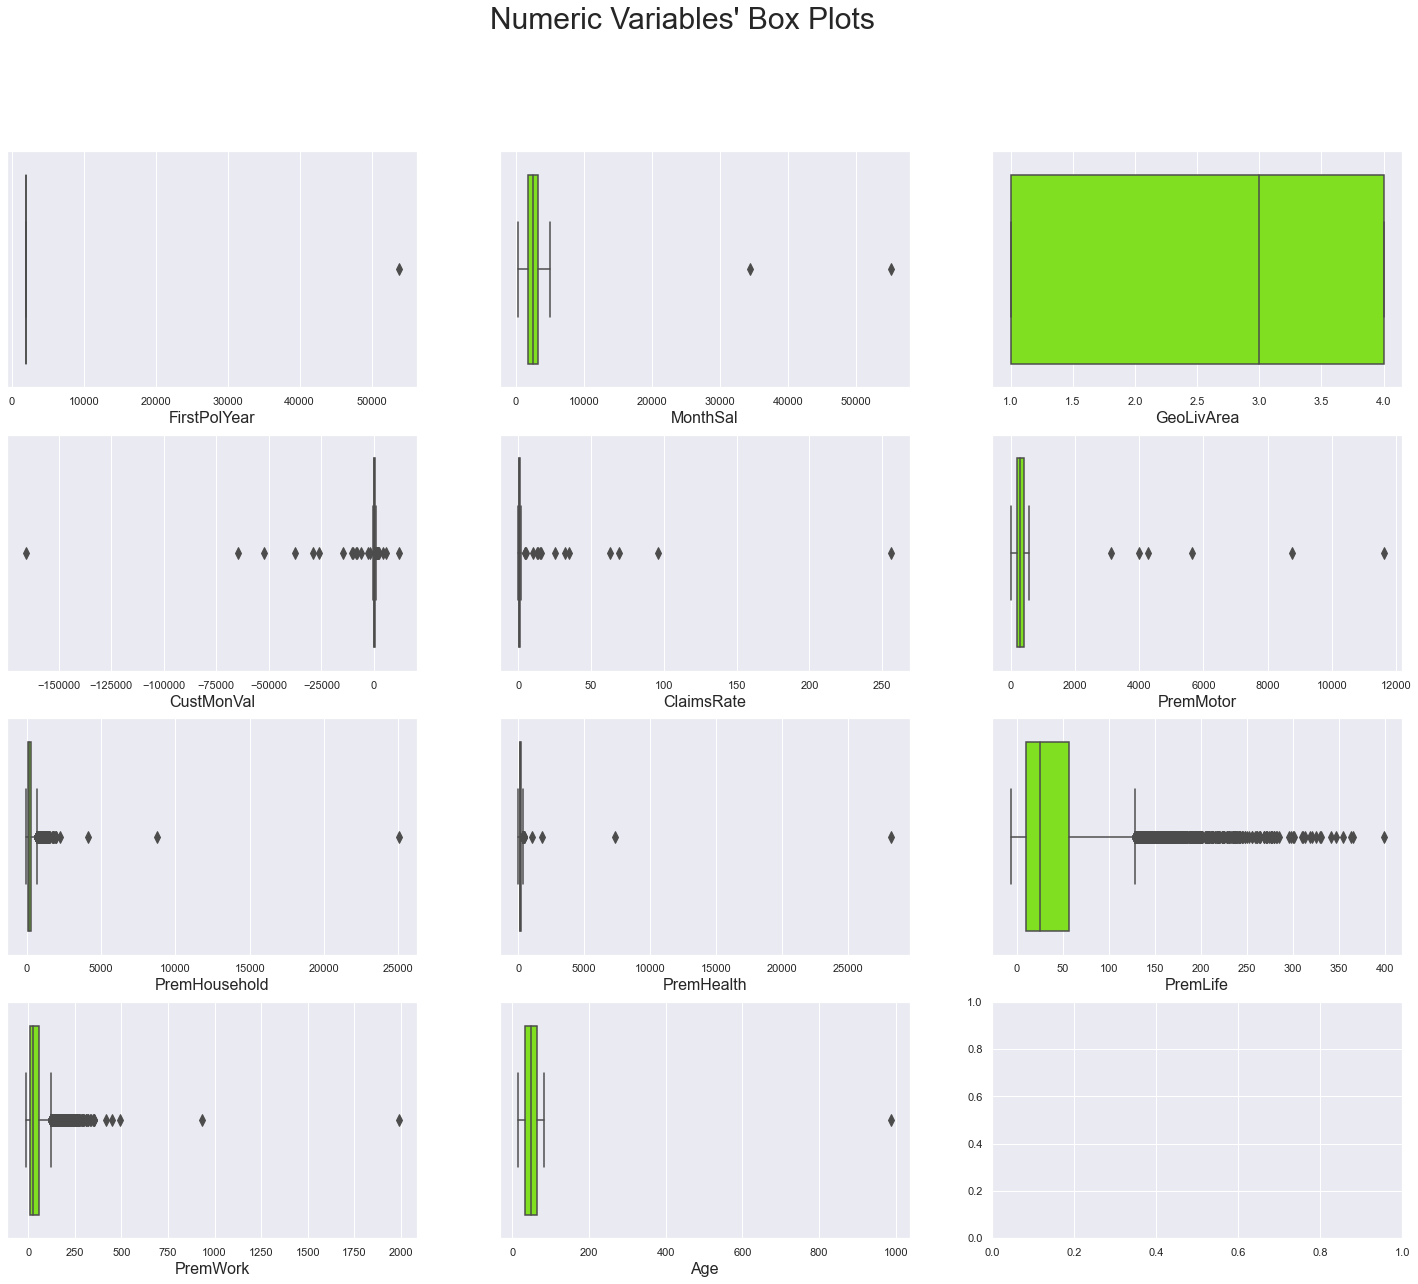

In [215]:
box_plot_all_vars(df)

In [216]:
filters1 = (
    (df['FirstPolYear']<=2016)
    &
    (df['MonthSal']<=5500)
    &
    (df['CustMonVal']>=-3000)
    &
    (df['CustMonVal']<=3000)
    &
    (df['ClaimsRate']<=6)
    &
    (df['PremMotor']<=700)
    &
    (df['PremHousehold']<=1500)
    &
    (df['PremHealth']<=760)
    &
    (df['PremLife']<=150)
    &
    (df['Age']<=85)
)

df_1 = df[filters1]
print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9553


In [217]:
# df_3['FirstPolYear'].unique()

In [218]:
q25 = df.quantile(.25)
q75 = df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters2.append(df[metric].between(llim, ulim, inclusive='both'))

filters2 = pd.Series(np.all(filters2, 0))
df_2=df.copy()
df_2['filters2'] = filters2.to_list()
df_2=df_2[df_2['filters2']!=False]
print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.8541


In [219]:
df_3 = df.copy()
df_3['filters1'] = filters1.to_list()
df_3['filters2'] = filters2
df_3 = df_3[(df_3['filters1']==True) | (df_3['filters2']==True)]
print('Percentage of data kept after removing outliers:', np.round(df_3.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9947


In [220]:
## print para comparar os dois metodos de outliers, e colocar que se escolheu so usar o manual
df_3.drop(columns=['filters1','filters2'], inplace=True)
print('Data shape before outliers removal:')
print(df.shape)
print('Data shape after outliers removal:')
print(df_1.shape)


Data shape before outliers removal:
(10293, 13)
Data shape after outliers removal:
(9833, 13)


In [221]:
df=df_1.copy()

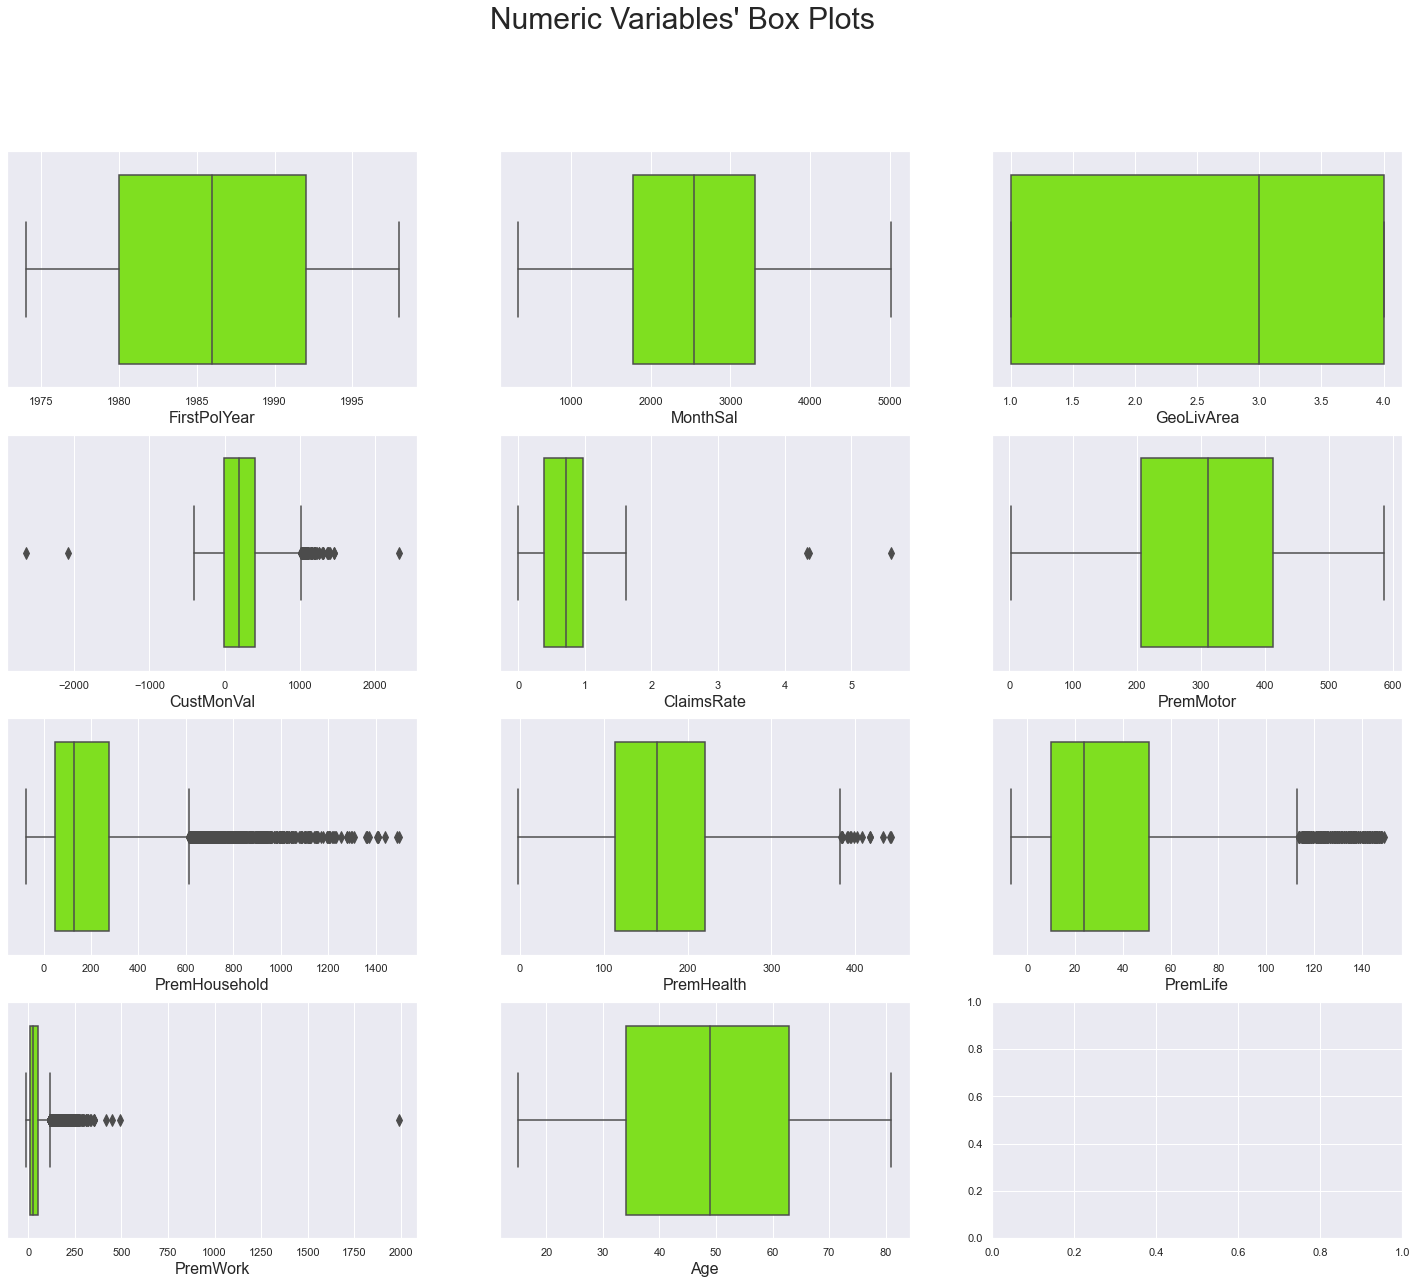

In [222]:
box_plot_all_vars(df)

In [223]:
df['FirstPolYear'].unique()

array([1985, 1991, 1990, 1986, 1979, 1988, 1981, 1976, 1983, 1977, 1998,
       1974, 1978, 1995, 1980, 1984, 1989, 1987, 1982, 1994, 1993, 1992,
       1997, 1996, 1975])

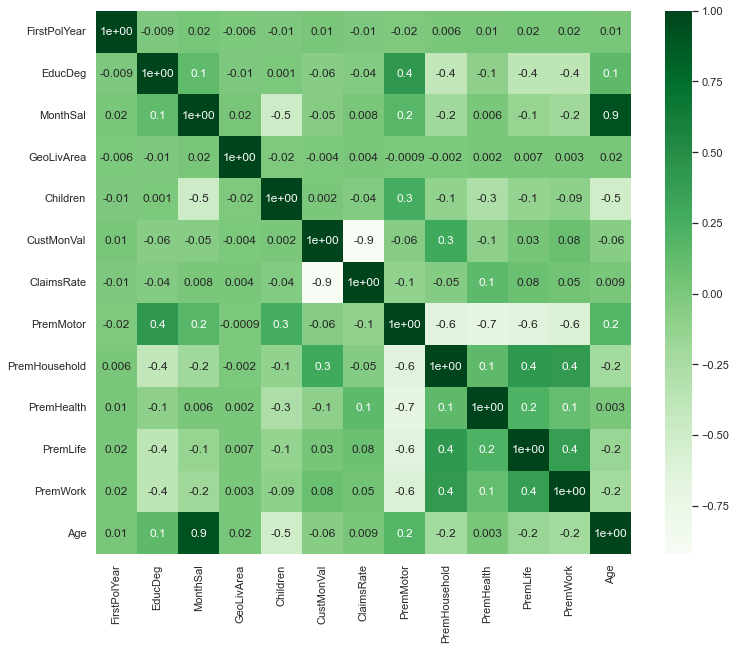

In [224]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Greens, fmt='.1')
    plt.show()
cor_pearson = df.corr()
cor_heatmap(cor_pearson)

##### -print dos uniques para ver que está coerente FEITO
##### -ver features, se se pode fazer mais alguma coisa
##### -imputar NAs de maneiras diferentes para se comparar (criar dfs diferentes para depois se testar nos clusterings)
##### -fazer gráficos de distribuição dos dados
##### -correlações?? para depois colocar scatters??
##### -normalizar - minmax
##### -onehot encoding
##### -PCA
##### -clustering
